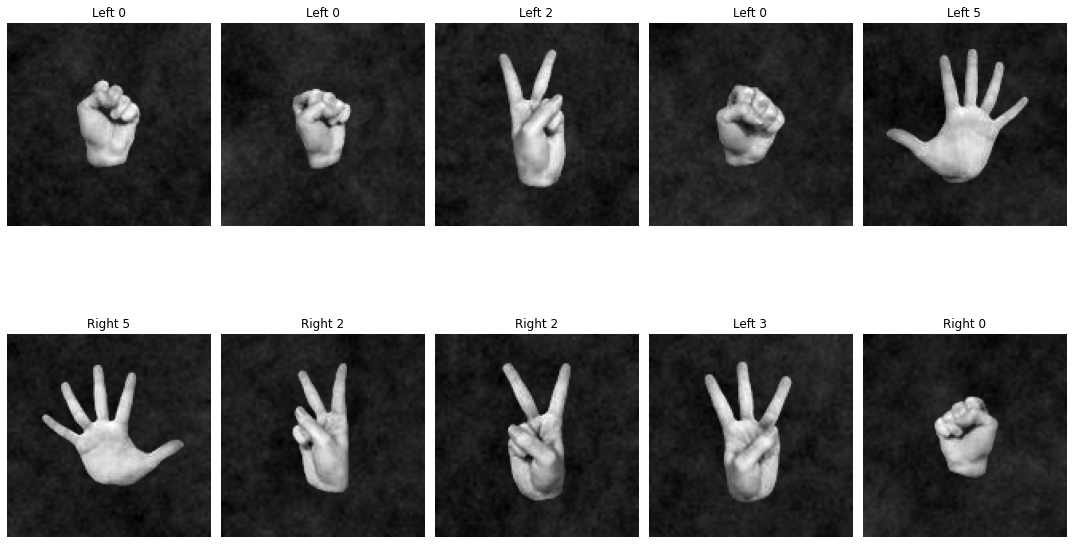

In [1]:
import os
from PIL import Image
import matplotlib.pyplot  as plt



def visua_img(file_path,n=10):
    
    img_list=os.listdir(file_path)
    fig,ax=plt.subplots(n//5,5,figsize=(15,10))
    
    for i,img_name in enumerate(img_list[:n]):
        img= Image.open(file_path+img_name)
        n_label=img_name[-6]
        hand_label=img_name[-5]
        ax[i//5][i%5].imshow(img,cmap='gray')
        ax[i//5][i%5].axis('off')
        ax[i//5][i%5].set_title('{} {}'.format( 'Left' if hand_label=='L' else 'Right',n_label))
    plt.tight_layout()
    plt.show()
visua_img('./train/',10)

In [2]:
import torch
torch.cuda.empty_cache()

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset
from torch import nn

seed = torch.initial_seed()

train_batch_size =  36 # Define train batch size
test_batch_size = 120  # Define test batch size (can be larger than train batch size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device='cpu'
print(device)



# define class to build dataset
class BuildDataset(Dataset):
    def __init__(self,file_path,transform,):
        self.file_path=file_path
        self.transform=transform
        self.image_list= os.listdir(file_path)       # list of image names
        random.shuffle(self.image_list)
        
    def __getitem__(self, idx):

        image_name = self.image_list[idx]
        # label 1 for left or right hand, label 2 for fingers count
        # label 1 : 'L' for 1, and 'R' for 0
        data, label1, label2 = Image.open(self.file_path+image_name), image_name[-5:-4], image_name[-6:-5]   
        label1 = int(label1=='L')
        label2= int(label2)
        return self.transform(data).to(device), torch.tensor(label1).to(device), torch.tensor(label2).to(device)
    
    def __len__(self):
        return len(self.image_list)
    
trf = T.Compose([T.ToTensor(), 
             T.Normalize((0.5,),(0.5,))])
train_dataset=BuildDataset('./train/',trf)
test_dataset=BuildDataset('./test/',trf)


cuda:0


In [18]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
)

len_train=len(train_loader)
len_val=len(test_loader)
print(len_train)
print(len_val)

#count=0
#fig,ax=plt.subplots(1,5,figsize=(15,10))
#for i,j in train_loader:
#    img=i[count].squeeze(0)
#    print(img.shape)
#    ax[count].imshow(img.to('cpu').numpy())
#    print(j[count])
#    if count==4:
#        break
#    count+=1

500
30


In [19]:
class MTLNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes_1,num_classes_2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        


        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=3, padding=0, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2,bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=192, out_channels=72, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
        )
        # decoder 1 for task 1, right or left hand
        self.decoder1=nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*72, 3*6*20),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*20, 3*4*4),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*4,num_classes_1),
        )
        # decoder 2 for task 2, fingers count
        self.decoder2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*72, 3*6*30),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*30, 3*4*8),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*8,num_classes_2),
        )
        
        self.classifier=nn.Softmax(dim=1)

    def forward(self, x, task_num=None):
        shared = self.encoder(x)
        
        # ---
        # gradient shared w.r.t parameters in encoder
        # ---
        
        #task_1 = shared.detach().clone()
        #task_2 = shared.detach().clone()
        
        
        # reduce the dimensions for linear layer input
        task_1=shared.view(shared.size(0),5*5*72)
        task_1 = self.decoder1(task_1)
        task_1 = self.classifier(task_1)
        
        task_2=shared.view(shared.size(0),5*5*72)
        task_2 = self.decoder2(task_2)
        task_2 = self.classifier(task_2)
        
        return task_1, task_2

In [20]:
import numpy as np
import tqdm

# initialize the number of classes for output
model = MTLNet(2,6)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00015,weight_decay=1e-5)

epochs = 10

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# every 90 iterations for log
log_interval = 100

loss_list = []
iteration_list = []
accuracy_list = []
count = 0

def _compute_loss(pred1,pred2,label1,label2):
    loss1=loss_fn(pred1,label1)
    loss2=loss_fn(pred2,label2)
    weight=F.softmax(torch.randn(2),dim=-1).to(device)
    #if weight[0]>weight[1]: weight[0],weight[1]=weight[1],weight[0]
    loss= weight[0]*loss1+weight[1]*loss2
    regular_loss= loss1+loss2
    return loss,regular_loss





if __name__ =='__main__':
    for epoch in tqdm.trange(epochs):
        for idx, (data, label1,label2) in enumerate(train_loader):
    
            # Calculate training loss on model
            pred_y1,pred_y2 = model(data)
            loss,regular_loss = _compute_loss(pred_y1,pred_y2,label1,label2)
            # zeros gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # save loss and accuracy for every 25 iterations
            if idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        idx * train_batch_size,
                        len_train*train_batch_size,
                        100.0 * idx / len_train,
                        regular_loss.item(),
                    )
                )                
                loss_list.append([loss.item(),regular_loss.item()])
                count += log_interval
                iteration_list.append(count)
                
                # calculate validation accuracy
                with torch.no_grad():
                    n_sample = len_val*test_batch_size
                    n_correct_task1 = 0
                    n_correct_task2 = 0
                    n_correct_both = 0
                    for idxx, (data, label1,label2) in enumerate(test_loader):
                        #data=data.to(device)
                        #labels=labels.to(device)
                        
                        pred_y1,pred_y2 = model(data)
                        pred_y1=pred_y1.to(device)
                        perd_y2=pred_y2.to(device)

                        n_correct_task1 += sum(
                            (torch.argmax(pred_y1, dim=1) == label1).type(torch.FloatTensor)
                        )
                        n_correct_task2 += sum(
                            (torch.argmax(pred_y2, dim=1) == label2).type(torch.FloatTensor)
                        )
                        n_correct_both += sum(
                            torch.tensor([torch.argmax(pred_y1, dim=1)[i] == label1[i] and 
                                          torch.argmax(pred_y2,dim=1)[i]==label2[i] for i in range(len(label1))]).type(torch.FloatTensor)
                        )
                    accuracy_list.append([i*100.0/n_sample for i in [n_correct_task1,n_correct_task2,n_correct_both]])
                    print(
                        "Validation set: number of correct label1: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct_task1), n_sample, 100.0 * n_correct_task1 / n_sample
                        )
                    )
                    print(
                        "Validation set: number of correct label2: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct_task2), n_sample, 100.0 * n_correct_task2 / n_sample
                        )
                    )
                    print(
                        "Validation set: number of correct both: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct_both), n_sample, 100.0 * n_correct_both / n_sample
                        )
                    )

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/18000 (0%)]	Loss: 2.483068
Validation set: number of correct label1: 1800/3600 accuracy: (50%)

Validation set: number of correct label2: 611/3600 accuracy: (17%)

Validation set: number of correct both: 303/3600 accuracy: (8%)

Train Epoch: 1 [3600/18000 (20%)]	Loss: 1.614134
Validation set: number of correct label1: 3453/3600 accuracy: (96%)

Validation set: number of correct label2: 3220/3600 accuracy: (89%)

Validation set: number of correct both: 3093/3600 accuracy: (86%)

Train Epoch: 1 [7200/18000 (40%)]	Loss: 1.419975
Validation set: number of correct label1: 3508/3600 accuracy: (97%)

Validation set: number of correct label2: 3379/3600 accuracy: (94%)

Validation set: number of correct both: 3294/3600 accuracy: (92%)

Train Epoch: 1 [10800/18000 (60%)]	Loss: 1.421355
Validation set: number of correct label1: 3591/3600 accuracy: (100%)

Validation set: number of correct label2: 3439/3600 accuracy: (96%)

Validation set: number of correct both: 3430/3600 accura

 10%|████████▎                                                                          | 1/10 [02:37<23:38, 157.64s/it]

Train Epoch: 2 [0/18000 (0%)]	Loss: 1.387777
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3494/3600 accuracy: (97%)

Validation set: number of correct both: 3493/3600 accuracy: (97%)

Train Epoch: 2 [3600/18000 (20%)]	Loss: 1.380916
Validation set: number of correct label1: 3593/3600 accuracy: (100%)

Validation set: number of correct label2: 3532/3600 accuracy: (98%)

Validation set: number of correct both: 3525/3600 accuracy: (98%)

Train Epoch: 2 [7200/18000 (40%)]	Loss: 1.409030
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3559/3600 accuracy: (99%)

Validation set: number of correct both: 3559/3600 accuracy: (99%)

Train Epoch: 2 [10800/18000 (60%)]	Loss: 1.379587
Validation set: number of correct label1: 3582/3600 accuracy: (100%)

Validation set: number of correct label2: 3560/3600 accuracy: (99%)

Validation set: number of correct both: 3542/3600 

 20%|████████████████▌                                                                  | 2/10 [05:17<21:11, 159.00s/it]

Train Epoch: 3 [0/18000 (0%)]	Loss: 1.365555
Validation set: number of correct label1: 3565/3600 accuracy: (99%)

Validation set: number of correct label2: 3560/3600 accuracy: (99%)

Validation set: number of correct both: 3525/3600 accuracy: (98%)

Train Epoch: 3 [3600/18000 (20%)]	Loss: 1.357368
Validation set: number of correct label1: 3595/3600 accuracy: (100%)

Validation set: number of correct label2: 3576/3600 accuracy: (99%)

Validation set: number of correct both: 3571/3600 accuracy: (99%)

Train Epoch: 3 [7200/18000 (40%)]	Loss: 1.357003
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3578/3600 accuracy: (99%)

Validation set: number of correct both: 3577/3600 accuracy: (99%)

Train Epoch: 3 [10800/18000 (60%)]	Loss: 1.357084
Validation set: number of correct label1: 3597/3600 accuracy: (100%)

Validation set: number of correct label2: 3577/3600 accuracy: (99%)

Validation set: number of correct both: 3574/3600 a

 30%|████████████████████████▉                                                          | 3/10 [07:54<18:26, 158.11s/it]

Train Epoch: 4 [0/18000 (0%)]	Loss: 1.366972
Validation set: number of correct label1: 3595/3600 accuracy: (100%)

Validation set: number of correct label2: 3571/3600 accuracy: (99%)

Validation set: number of correct both: 3566/3600 accuracy: (99%)

Train Epoch: 4 [3600/18000 (20%)]	Loss: 1.356855
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3578/3600 accuracy: (99%)

Validation set: number of correct both: 3577/3600 accuracy: (99%)

Train Epoch: 4 [7200/18000 (40%)]	Loss: 1.356869
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3591/3600 accuracy: (100%)

Validation set: number of correct both: 3591/3600 accuracy: (100%)

Train Epoch: 4 [10800/18000 (60%)]	Loss: 1.362416
Validation set: number of correct label1: 3598/3600 accuracy: (100%)

Validation set: number of correct label2: 3589/3600 accuracy: (100%)

Validation set: number of correct both: 3587/36

 40%|█████████████████████████████████▏                                                 | 4/10 [10:33<15:51, 158.53s/it]

Train Epoch: 5 [0/18000 (0%)]	Loss: 1.356876
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3593/3600 accuracy: (100%)

Validation set: number of correct both: 3593/3600 accuracy: (100%)

Train Epoch: 5 [3600/18000 (20%)]	Loss: 1.356887
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3582/3600 accuracy: (100%)

Validation set: number of correct both: 3582/3600 accuracy: (100%)

Train Epoch: 5 [7200/18000 (40%)]	Loss: 1.356854
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3587/3600 accuracy: (100%)

Validation set: number of correct both: 3587/3600 accuracy: (100%)

Train Epoch: 5 [10800/18000 (60%)]	Loss: 1.358621
Validation set: number of correct label1: 3591/3600 accuracy: (100%)

Validation set: number of correct label2: 3581/3600 accuracy: (99%)

Validation set: number of correct both: 3572

 50%|█████████████████████████████████████████▌                                         | 5/10 [13:11<13:11, 158.31s/it]

Train Epoch: 6 [0/18000 (0%)]	Loss: 1.357685
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3578/3600 accuracy: (99%)

Validation set: number of correct both: 3578/3600 accuracy: (99%)

Train Epoch: 6 [3600/18000 (20%)]	Loss: 1.356877
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3583/3600 accuracy: (100%)

Validation set: number of correct both: 3583/3600 accuracy: (100%)

Train Epoch: 6 [7200/18000 (40%)]	Loss: 1.356941
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3589/3600 accuracy: (100%)

Validation set: number of correct both: 3588/3600 accuracy: (100%)

Train Epoch: 6 [10800/18000 (60%)]	Loss: 1.356854
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3583/3600 accuracy: (100%)

Validation set: number of correct both: 3583/

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [15:51<10:35, 158.90s/it]

Train Epoch: 7 [0/18000 (0%)]	Loss: 1.358780
Validation set: number of correct label1: 3591/3600 accuracy: (100%)

Validation set: number of correct label2: 3588/3600 accuracy: (100%)

Validation set: number of correct both: 3579/3600 accuracy: (99%)

Train Epoch: 7 [3600/18000 (20%)]	Loss: 1.356854
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3590/3600 accuracy: (100%)

Validation set: number of correct both: 3590/3600 accuracy: (100%)

Train Epoch: 7 [7200/18000 (40%)]	Loss: 1.356956
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3597/3600 accuracy: (100%)

Validation set: number of correct both: 3596/3600 accuracy: (100%)

Train Epoch: 7 [10800/18000 (60%)]	Loss: 1.357613
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3595/3600 accuracy: (100%)

Validation set: number of correct both: 3594

 70%|██████████████████████████████████████████████████████████                         | 7/10 [18:27<07:53, 157.73s/it]

Train Epoch: 8 [0/18000 (0%)]	Loss: 1.356854
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3594/3600 accuracy: (100%)

Validation set: number of correct both: 3593/3600 accuracy: (100%)

Train Epoch: 8 [3600/18000 (20%)]	Loss: 1.356857
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3594/3600 accuracy: (100%)

Validation set: number of correct both: 3594/3600 accuracy: (100%)

Train Epoch: 8 [7200/18000 (40%)]	Loss: 1.356858
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3595/3600 accuracy: (100%)

Validation set: number of correct both: 3595/3600 accuracy: (100%)

Train Epoch: 8 [10800/18000 (60%)]	Loss: 1.356858
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3589/3600 accuracy: (100%)

Validation set: number of correct both: 358

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [21:11<05:19, 159.75s/it]

Train Epoch: 9 [0/18000 (0%)]	Loss: 1.356858
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3591/3600 accuracy: (100%)

Validation set: number of correct both: 3591/3600 accuracy: (100%)

Train Epoch: 9 [3600/18000 (20%)]	Loss: 1.356854
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3597/3600 accuracy: (100%)

Validation set: number of correct both: 3597/3600 accuracy: (100%)

Train Epoch: 9 [7200/18000 (40%)]	Loss: 1.383911
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3567/3600 accuracy: (99%)

Validation set: number of correct both: 3567/3600 accuracy: (99%)

Train Epoch: 9 [10800/18000 (60%)]	Loss: 1.356854
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3589/3600 accuracy: (100%)

Validation set: number of correct both: 3588/

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [23:49<02:39, 159.46s/it]

Train Epoch: 10 [0/18000 (0%)]	Loss: 1.356855
Validation set: number of correct label1: 3599/3600 accuracy: (100%)

Validation set: number of correct label2: 3588/3600 accuracy: (100%)

Validation set: number of correct both: 3587/3600 accuracy: (100%)

Train Epoch: 10 [3600/18000 (20%)]	Loss: 1.357048
Validation set: number of correct label1: 3600/3600 accuracy: (100%)

Validation set: number of correct label2: 3592/3600 accuracy: (100%)

Validation set: number of correct both: 3592/3600 accuracy: (100%)

Train Epoch: 10 [7200/18000 (40%)]	Loss: 1.356854
Validation set: number of correct label1: 3595/3600 accuracy: (100%)

Validation set: number of correct label2: 3587/3600 accuracy: (100%)

Validation set: number of correct both: 3582/3600 accuracy: (100%)

Train Epoch: 10 [10800/18000 (60%)]	Loss: 1.356923
Validation set: number of correct label1: 3596/3600 accuracy: (100%)

Validation set: number of correct label2: 3590/3600 accuracy: (100%)

Validation set: number of correct both:

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [26:31<00:00, 159.19s/it]


|RUN|Optimizer| Batch size | lr | Weight decay | Best accuracy|Epoch|
|---|---|---|---|---|---|---|
|1  |Adam| 36 |0.00015|1e-5|100%|4|

%#|2|Adam|72 |0.00002|1e-5|91%|6|
%#|5|RMSprop|36|0.00003|1e-6|91%|10|
%#|6|RMSprop|50|0.00001|1e-6|87%|6|
%#|7|RMSprop|36|0.000015|1e-6|99%|9|

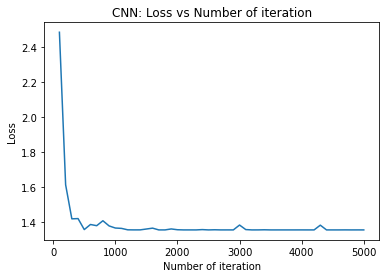

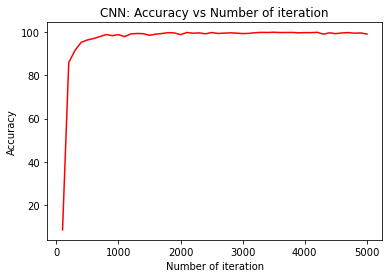

In [21]:
import matplotlib.pyplot as plt

# visualization loss
plt.plot(iteration_list, [i[1] for i in loss_list])
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list, [i[2] for i in accuracy_list], color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

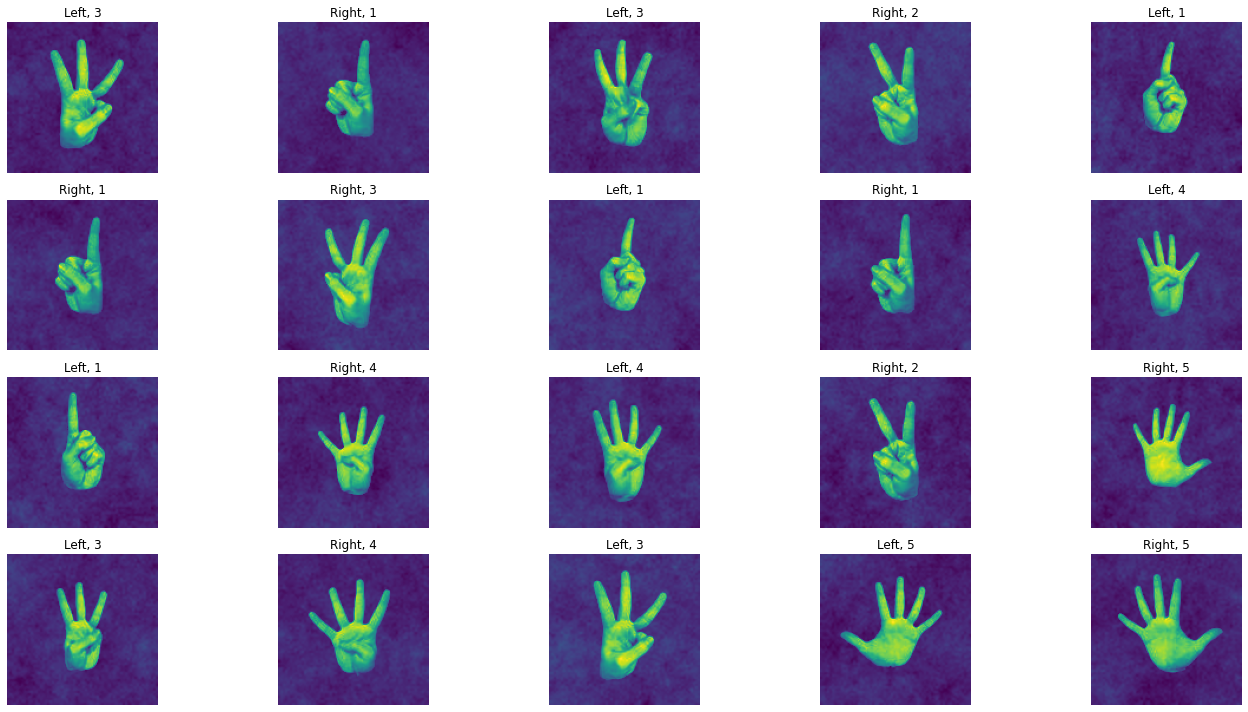

In [25]:
def get_prediction(file_path, num, transform):
    
    imgs = os.listdir(file_path)
    random.shuffle(imgs)
    imgs=imgs[:num]
    imgs=[Image.open(file_path+i) for i in imgs]


    inp = list(map(lambda x: transform(x) , imgs))
    inp = torch.stack(inp,dim=0)
    inp=inp.to(device)    
    pred1,pred2= model(inp)
    
    def label_pred(pred1,pred2):
        l1=torch.argmax(pred1).item()
        l2=torch.argmax(pred2).item()
        return ('Left, ' if l1==1 else 'Right, ')+str(l2)
        
    pred= (lambda x,y: [label_pred(x[i],y[i]) for i in range(len(pred1))])(pred1,pred2)
    
    fig,ax = plt.subplots(num//5,5,figsize=(20,10))
    for idx,image in enumerate(imgs):
        img=imgs[idx]
        ax[idx//5][idx%5].axis('off')
        ax[idx//5][idx%5].imshow(img)
        ax[idx//5][idx%5].set_title(pred[idx])
    plt.tight_layout()
    plt.show()
        
    pass
        
n_pred=20

get_prediction('./test/',n_pred, trf)